In [1]:
# Feed each chunk into neural network
# Feed acc (x,y,z,mag) + gyr (x,y,z,mag)

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [3]:
import sys
sys.path.append("../gaitkeeper")
from load import IDNET_PATH, get_reference_data
from preprocess import generate_walk_chunks, normalize_sensor_data

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import random
SEED = 111
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

### load all walk data

In [7]:
dfs = []
for folder in tqdm(list(IDNET_PATH.glob("*"))):
    user_id = int(folder.stem[1:4])
    walk_id = int(folder.stem[6:9])
    df = get_reference_data(user_id, walk_id).reset_index()
    df.insert(0, "walk_id", walk_id)
    df.insert(0, "user_id", user_id)
    dfs.append(df)
df = pd.concat(dfs)

In [8]:
# split into chunks
# note don't need training/validation because autoencoder
chunks = []
for (user_id, walk_id), subdf in df.groupby(["user_id", "walk_id"]):
    chunks.extend(list(generate_walk_chunks(subdf, chunksize=256)))

In [9]:
user_labels = [chunk["user_id"].iloc[0] for chunk in chunks]

In [10]:
train, test = train_test_split(chunks, test_size=0.1, shuffle=True, stratify=user_labels)

In [11]:
len(train), len(test)

(9463, 1052)

In [178]:
# why CNN - translational invariance!

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input to conv1d needs to be (batch_size, channels, signal_length)
        # try downsampling?
        # encoder
        self.encoder = nn.Sequential(*[
            nn.Conv1d(2, 8, 5, padding=2, padding_mode="replicate"), torch.nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 12, 3, padding=1, padding_mode="replicate"), torch.nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(12, 24, 3, padding=1, padding_mode="replicate"), torch.nn.ReLU(),
            nn.MaxPool1d(2), # Embedding sohuld span negative values (Tanh vs. ReLU/Sigmoid)
            nn.Flatten()
        ])
        self.bottleneck = nn.Linear(in_features=24 * 32, out_features=64)
        # decoder
        self.decoder = nn.Sequential(*[
            nn.Conv1d(2, 24, 1, padding_mode="replicate"), torch.nn.ReLU(),
            nn.Upsample(mode="linear", scale_factor=2, align_corners=False),
            nn.Conv1d(24, 12, 1, padding_mode="replicate"), torch.nn.ReLU(),
            nn.Upsample(mode="linear", scale_factor=2, align_corners=False),
            nn.Conv1d(12, 8, 1, padding_mode="replicate"),  # Output must span negative values (Tanh vs. ReLU/Sigmoid)
            nn.Upsample(mode="linear", scale_factor=2, align_corners=False),
            nn.Conv1d(8, 2, 1, padding_mode="replicate")  # Output must span negative values (Tanh vs. ReLU/Sigmoid)
        ])
    def forward(self, x):
        encoder = self.encoder(x)
        embedding = self.bottleneck(encoder).view(-1,2,32)
        reconstruction = self.decoder(embedding)
        return reconstruction, embedding

In [179]:
model = AutoEncoder().to(DEVICE)

In [180]:
summary(model, (2, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 8, 256]              88
              ReLU-2               [-1, 8, 256]               0
         MaxPool1d-3               [-1, 8, 128]               0
            Conv1d-4              [-1, 12, 128]             300
              ReLU-5              [-1, 12, 128]               0
         MaxPool1d-6               [-1, 12, 64]               0
            Conv1d-7               [-1, 24, 64]             888
              ReLU-8               [-1, 24, 64]               0
         MaxPool1d-9               [-1, 24, 32]               0
          Flatten-10                  [-1, 768]               0
           Linear-11                   [-1, 64]          49,216
           Conv1d-12               [-1, 24, 32]              72
             ReLU-13               [-1, 24, 32]               0
         Upsample-14               [-1,

In [181]:
exinp.view(1,512).shape

torch.Size([1, 512])

In [182]:
class GaitDataset(torch.utils.data.Dataset):
    """Dataset for gait recording chunks."""
    def __init__(self, dfs):
        """
        dfs: list of DataFrames corresponding to chunked data
        """
        self.dfs = dfs
    def __getitem__(self, idx):
        chunk = self.dfs[idx]
        user_id = chunk["user_id"].iloc[0]
        walk_id = chunk["walk_id"].iloc[0]
        acc_mag = normalize_sensor_data(chunk, "linearaccelerometer")
        gyro_mag = normalize_sensor_data(chunk, "gyroscope")
        out = np.stack([acc_mag, gyro_mag])
        return torch.from_numpy(out), user_id, walk_id
    def __len__(self):
        return len(self.dfs)

In [183]:
bs = 64

In [184]:
train_dataset = GaitDataset(train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [185]:
# Test that model can take an input
exinp = train_dataset[0][0].reshape(1,2,256).float().to(DEVICE)
exinp.shape, model(exinp)[0].shape, model(exinp)[1].shape

(torch.Size([1, 2, 256]), torch.Size([1, 2, 256]), torch.Size([1, 2, 32]))

In [186]:
valid_dataset = GaitDataset(test)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs)

In [187]:
# Test model on a minibatch
model(next(iter(train_dataloader))[0].float().cuda())[0].shape

torch.Size([64, 2, 256])

In [195]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()
epochs = 50

In [196]:
# Store embeddings
train_embeddings = []
valid_embeddings = []

for epoch in tqdm(range(epochs)):
    loss = 0
    model.train()
    for i, (x, user_ids, walk_ids) in enumerate(tqdm(train_dataloader)):
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        x = x.float().to(DEVICE)
        # compute reconstructions
        recon, embedding = model(x)
        # compute training reconstruction loss
        train_loss = criterion(recon, x)
        # compute accumulated gradients
        train_loss.backward()
        # perform parameter update based on current gradients
        optimizer.step()
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        if epoch == epochs - 1:
            for j, emb in enumerate(embedding.reshape(embedding.shape[0],-1)):
                train_embeddings.append((user_ids[j].item(), walk_ids[j].item(), emb.cpu().detach().numpy().flatten()))
    
    
    # compute validation metric
    valid_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (x, user_ids, walk_ids) in enumerate(valid_dataloader):
            x = x.float().to(DEVICE)
            recon, embedding = model(x)
            valid_loss += criterion(recon, x).item()
        
    # compute the epoch training loss
    loss /= len(train_dataloader)
    valid_loss /= len(valid_dataloader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, valid_loss = {:.6f}".format(epoch + 1, epochs, loss, valid_loss))


epoch : 1/50, loss = 0.034092, valid_loss = 0.025886



epoch : 2/50, loss = 0.025011, valid_loss = 0.024022



epoch : 3/50, loss = 0.023997, valid_loss = 0.023527



epoch : 4/50, loss = 0.023380, valid_loss = 0.023101



epoch : 5/50, loss = 0.023018, valid_loss = 0.023473



epoch : 6/50, loss = 0.022811, valid_loss = 0.022482



epoch : 7/50, loss = 0.022664, valid_loss = 0.022501



epoch : 8/50, loss = 0.022524, valid_loss = 0.022256



epoch : 9/50, loss = 0.022444, valid_loss = 0.022147



epoch : 10/50, loss = 0.022316, valid_loss = 0.022300



epoch : 11/50, loss = 0.022363, valid_loss = 0.022086



epoch : 12/50, loss = 0.022232, valid_loss = 0.021878



epoch : 13/50, loss = 0.022186, valid_loss = 0.022008



epoch : 14/50, loss = 0.022058, valid_loss = 0.021787



epoch : 15/50, loss = 0.022097, valid_loss = 0.021784



epoch : 16/50, loss = 0.022057, valid_loss = 0.021714



epoch : 17/50, loss = 0.021982, valid_loss = 0.021749



epoch : 18/50, loss = 0.021956, valid_loss = 0.021793



epoch : 19/50, loss = 0.021905, valid_loss = 0.021782



epoch : 20/50, loss = 0.021880, valid_loss = 0.022137



epoch : 21/50, loss = 0.021911, valid_loss = 0.022160



epoch : 22/50, loss = 0.021749, valid_loss = 0.021510



epoch : 23/50, loss = 0.021745, valid_loss = 0.021528



epoch : 24/50, loss = 0.021709, valid_loss = 0.021632



epoch : 25/50, loss = 0.021712, valid_loss = 0.021518



epoch : 26/50, loss = 0.021678, valid_loss = 0.022099



epoch : 27/50, loss = 0.021637, valid_loss = 0.021438



epoch : 28/50, loss = 0.021666, valid_loss = 0.021466



epoch : 29/50, loss = 0.021574, valid_loss = 0.021398



epoch : 30/50, loss = 0.021618, valid_loss = 0.021810



epoch : 31/50, loss = 0.021584, valid_loss = 0.021377



epoch : 32/50, loss = 0.021523, valid_loss = 0.021292



epoch : 33/50, loss = 0.021548, valid_loss = 0.021375



epoch : 34/50, loss = 0.021436, valid_loss = 0.021490



epoch : 35/50, loss = 0.021439, valid_loss = 0.021371



epoch : 36/50, loss = 0.021437, valid_loss = 0.021291



epoch : 37/50, loss = 0.021447, valid_loss = 0.021277



epoch : 38/50, loss = 0.021437, valid_loss = 0.021360



epoch : 39/50, loss = 0.021349, valid_loss = 0.021220



epoch : 40/50, loss = 0.021411, valid_loss = 0.021298



epoch : 41/50, loss = 0.021376, valid_loss = 0.021235



epoch : 42/50, loss = 0.021286, valid_loss = 0.021352



epoch : 43/50, loss = 0.021408, valid_loss = 0.021284



epoch : 44/50, loss = 0.021301, valid_loss = 0.021675



epoch : 45/50, loss = 0.021332, valid_loss = 0.021258



epoch : 46/50, loss = 0.021260, valid_loss = 0.021141



epoch : 47/50, loss = 0.021229, valid_loss = 0.021466



epoch : 48/50, loss = 0.021233, valid_loss = 0.021238



epoch : 49/50, loss = 0.021220, valid_loss = 0.021090



epoch : 50/50, loss = 0.021254, valid_loss = 0.021348



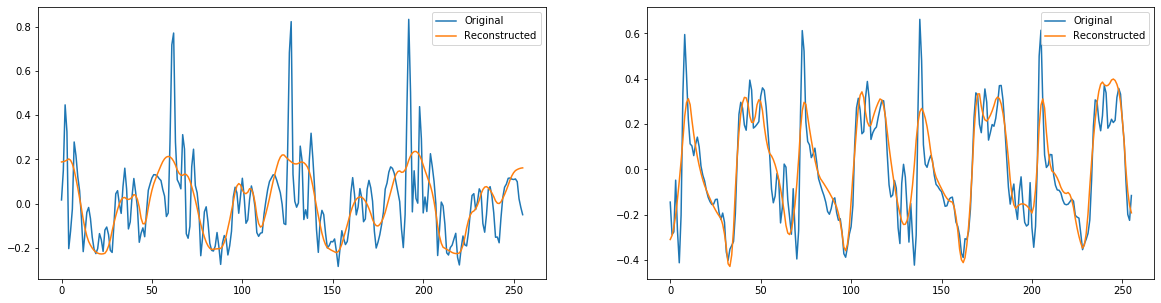

In [197]:
sample = random.randint(0, len(train)-1)
f, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(train_dataset[sample][0][0], label="Original")
ax[0].plot(model(train_dataset[sample][0].reshape(-1,2,256).float().to(DEVICE))[0].cpu().detach().numpy()[0,0,:], label="Reconstructed")
ax[1].plot(train_dataset[sample][0][1], label="Original")
ax[1].plot(model(train_dataset[sample][0].reshape(-1,2,256).float().to(DEVICE))[0].cpu().detach().numpy()[0,1,:], label="Reconstructed")
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

In [198]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler

In [199]:
### Compute similarity metric on training and validation sets
user_ids, walk_ids, embeddings = zip(*train_embeddings)
embeddings = np.array(embeddings)  # (N, n_features)

In [200]:
print(embeddings.shape)
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

(9463, 64)


In [201]:
multiindex = pd.MultiIndex.from_arrays([user_ids, walk_ids], names=["user_id", "walk_id"])
simi_dot = pd.DataFrame(np.dot(embeddings, embeddings.T), index=multiindex, columns=multiindex)
simi_cos = pd.DataFrame(cosine_similarity(embeddings, embeddings), index=multiindex, columns=multiindex)

In [202]:
def aggregate_similarities_mean(simi):
    # Fill in diagonals so they don't affect the aggregation
    np.fill_diagonal(simi.values, np.nan)
    pool = simi.groupby(by=["user_id", "walk_id"], axis=0).mean().groupby(by=["user_id", "walk_id"], axis=1).mean()
    return pool

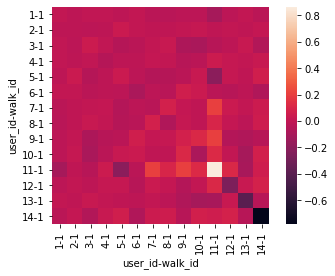

In [203]:
sns.heatmap(aggregate_similarities_mean(simi_dot), square=True)

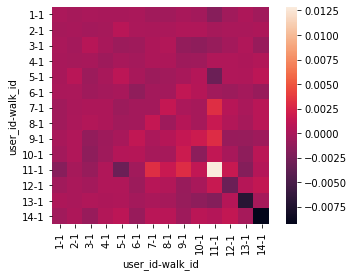

In [204]:
sns.heatmap(aggregate_similarities_mean(simi_cos), square=True)